In [1]:
import wandb
from tqdm.auto import tqdm
import numpy as np

from monai.apps import DecathlonDataset
from monai.data import DataLoader, decollate_batch
from monai.losses import DiceLoss
from monai.config import print_config
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,

    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism

import torch
print_config()

/Users/tiendzung/anaconda3/envs/mri/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.3.1
Numpy version: 1.26.4
Pytorch version: 2.3.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 96bfda00c6bd290297f5e3514ea227c6be4d08b4
MONAI __file__: /Users/<username>/anaconda3/envs/mri/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 10.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.18.1
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSI

In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tiendung050803. Use `wandb login --relogin` to force relogin


True

In [3]:
wandb.init(project="monai-brain-tumor-segmentation")

In [4]:
config = wandb.config
config.seed = 0
config.roi_size = [224, 224, 144]
config.batch_size = 1
config.num_workers = 4
config.max_train_images_visualized = 3
config.max_val_images_visualized = 3
config.dice_loss_smoothen_numerator = 0
config.dice_loss_smoothen_denominator = 1e-5
config.dice_loss_squared_prediction = True
config.dice_loss_target_onehot = False
config.dice_loss_apply_sigmoid = True
config.initial_learning_rate = 1e-4
config.weight_decay = 1e-5
config.max_train_epochs = 50
config.validation_intervals = 1
config.dataset_dir = "./dataset/"
config.checkpoint_dir = "./checkpoints"
config.inference_roi_size = (128, 128, 64)
config.max_prediction_images_visualized = 20

In [5]:
from typing import Optional, List
import monai
import monai.transforms
import SimpleITK as sitk
import numpy as np 
import torch
from lightning import LightningDataModule
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split
from torchvision.transforms import transforms
import json
import os
import rootutils

rootutils.setup_root(search_from="/Users/tiendzung/Project/spine-segmentation/notebooks/logger_wandb.ipynb", indicator="setup.py", pythonpath=True)
from src.data.transforms import array

# always starting with vanilla dataset, like its a norm to me now
class SpiderDataset(Dataset):
    num_class = 15
    def __init__(self, 
                 data = None,
                 data_dir: str = "", 
                 json_path: str = "",
                 ):
        super().__init__()
        self.data = list()
        self.data_dir = data_dir
        if data is not None:
            self.data = data
        else:
            if data_dir == "" or json_path == "":
                raise AssertionError("No dataset ?")
            self.setup(json_path)
    
    def setup(self, json_path):
        json_object = json.load(open(json_path, "r"))
        keys = json_object.keys()
        if "training" in keys:
            for key in keys:
                self.data.extend(json_object[key])
        else:
            try:
                self.data.extend(json_object)
            except:
                raise InsertionError("Something wrong with json file, cannot load or do anything, at all")
    
    def get_item(self, index: int):
        output = dict()
        output["image"] = ""
        output["label"] = ""
        if isinstance(self.data[index]["image"], list):
            output["image"] = [os.path.join(self.data_dir, image) for image in self.data[index]["image"]]
        else:
            # Add for debugging
            path = os.path.join(self.data_dir, self.data[index]["image"])
            output["image"] = path ##Set to 4 because the model_inferr in validation_step
        output["label"] = os.path.join(self.data_dir, self.data[index]["label"])
        return output
    
    # In case they query in list of index
    def __getitem__(self, index):
        output = None
        if not isinstance(index, int):
            output = []
            for id in index:
                output.append(self.get_item(id))
        else:
            output = self.get_item(int(index))
        
        return output
    
    def __len__(self) -> int:
        return len(self.data)
    
    

class SpiderTransformedDataset(Dataset):
    def __init__(self, 
                 dataset: SpiderDataset,
                 transform: monai.transforms.Compose):
        super().__init__()
        self.dataset = dataset
        self.transform = transform
    
    def __getitem__(self, index):
        output = None
        
        if not isinstance(index, int):
            output = []
            for id in index:
                output.append(self.transform(self.dataset[id]))
        else:
            output = self.transform(self.dataset[int(index)])

        return output
    
    def __len__(self) -> int:
        return len(self.dataset)

In [21]:
dataset = SpiderDataset(data_dir = "/Users/tiendzung/Downloads/spine_nii", json_path="/Users/tiendzung/Project/spine-segmentation/data/jsons/spine_v3.json")
# dataset = SpiderDataset(data_dir = "./data/dataset", json_path="/data/hpc/spine/jsons/brats21_folds.json")

transform = monai.transforms.Compose([monai.transforms.LoadImaged(keys=["image", "label"], image_only = False),
                                        array.ConvertToMultiChannelBasedOnSpiderClassesdSemantic(keys=["label"]),
                                        monai.transforms.EnsureChannelFirstd(keys=["image"]),
                                        Spacingd(
                                        keys=["image", "label"],
                                        pixdim=(1.0, 1.0, 1.0),
                                        mode=("bilinear", "nearest"),
                                    ),
                                    #   monai.transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys=["label"]),
                                    #   monai.transforms.Resized(keys=["image", "label"], spatial_size=(250, 250, 155)),
                                        monai.transforms.ToTensord(keys=["image", "label"]),])

transformed = SpiderTransformedDataset(dataset, transform)
data = dataset[0]
images = transformed[10]
print(data)
print(images["image"].size(), images["image"].dtype)
print(images["label"].size(), images["label"].dtype)
print(images.keys())
print("------------------")
print(images['image_meta_dict'])
print("------------------")
print(images['label_meta_dict'])
print(images["label"].size())

# res = 0
# for image in transformed:
#     res = max(res, image["label"].size(0))

# print(res)

{'image': '/Users/tiendzung/Downloads/spine_nii/images/1_t1.nii.gz', 'label': '/Users/tiendzung/Downloads/spine_nii/masks/1_t1.nii.gz'}
torch.Size([1, 80, 280, 281]) torch.float32
torch.Size([3, 80, 280, 281]) torch.float32
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
------------------
{'sizeof_hdr': array(348, dtype=int32), 'extents': array(0, dtype=int32), 'session_error': array(0, dtype=int16), 'dim_info': array(0, dtype=uint8), 'dim': array([  3,  25, 448, 427,   1,   1,   1,   1], dtype=int16), 'intent_p1': array(0., dtype=float32), 'intent_p2': array(0., dtype=float32), 'intent_p3': array(0., dtype=float32), 'intent_code': array(0, dtype=int16), 'datatype': array(4, dtype=int16), 'bitpix': array(16, dtype=int16), 'slice_start': array(0, dtype=int16), 'pixdim': array([1.        , 3.293679  , 0.625     , 0.65749806, 0.        ,
       0.        , 0.        , 0.        ], dtype=float32), 'vox_offset': array(0., dtype=float32), 'scl_slope': array(nan, dtype=fl

In [22]:
def log_data_samples_into_tables(
    sample_image: np.array,
    sample_label: np.array,
    split: str = None,
    data_idx: int = None,
    table: wandb.Table = None,
):
    print(sample_image.shape)
    num_channels, num_slices, _, _ = sample_image.shape
    with tqdm(total=num_slices, leave=False) as progress_bar:
        for slice_idx in range(num_slices):
            ground_truth_wandb_images = []
            for channel_idx in range(num_channels):
                ground_truth_wandb_images.append(
                    wandb.Image(
                        sample_image[channel_idx, slice_idx, :, :],
                        masks={
                            "ground-truth/Tumor-Core": {
                                "mask_data": sample_label[0, slice_idx, :, :],
                                "class_labels": {0: "background", 1: "Tumor Core"},
                            },
                            "ground-truth/Whole-Tumor": {
                                "mask_data": sample_label[1, slice_idx, :, :] * 2,
                                "class_labels": {0: "background", 2: "Whole Tumor"},
                            },
                            "ground-truth/Enhancing-Tumor": {
                                "mask_data": sample_label[2, slice_idx, :, :] * 3,
                                "class_labels": {0: "background", 3: "Enhancing Tumor"},
                            },
                        },
                    )
                )
            table.add_data(split, data_idx, slice_idx, *ground_truth_wandb_images)
            progress_bar.update(1)
    return table

table = wandb.Table(
    columns=[
        "Split",
        "Data Index",
        "Slice Index",
        "Image-Channel"
    ]
)

In [26]:
# Generate visualizations for train_dataset
max_samples = (
    min(config.max_train_images_visualized, len(transformed))
    if config.max_train_images_visualized > 0
    else len(transformed)
)
progress_bar = tqdm(
    enumerate(transformed.__getitem__([9, 10, 12])),
    total=max_samples,
    desc="Generating Train Dataset Visualizations:",
)
for data_idx, sample in progress_bar:
    sample_image = sample["image"].detach().cpu().numpy()
    sample_label = sample["label"].detach().cpu().numpy()
    table = log_data_samples_into_tables(
        sample_image,
        sample_label,
        split="train",
        data_idx=data_idx,
        table=table,
    )

# # Generate visualizations for val_dataset
# max_samples = (
#     min(config.max_val_images_visualized, len(val_dataset))
#     if config.max_val_images_visualized > 0
#     else len(val_dataset)
# )
# progress_bar = tqdm(
#     enumerate(val_dataset[:max_samples]),
#     total=max_samples,
#     desc="Generating Validation Dataset Visualizations:",
# )
# for data_idx, sample in progress_bar:
#     sample_image = sample["image"].detach().cpu().numpy()
#     sample_label = sample["label"].detach().cpu().numpy()
#     table = log_data_samples_into_tables(
#         sample_image,
#         sample_label,
#         split="val",
#         data_idx=data_idx,
#         table=table,
#     )

# Log the table to your dashboard
wandb.log({"Tumor-Segmentation-Data": table})
     

Generating Train Dataset Visualizations::   0%|          | 0/3 [00:00<?, ?it/s]

(1, 68, 280, 280)


Generating Train Dataset Visualizations::  33%|███▎      | 1/3 [00:00<00:01,  1.60it/s]

(1, 80, 280, 281)


Generating Train Dataset Visualizations::  67%|██████▋   | 2/3 [00:01<00:00,  1.55it/s]

(1, 63, 280, 280)


Generating Train Dataset Visualizations:: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]


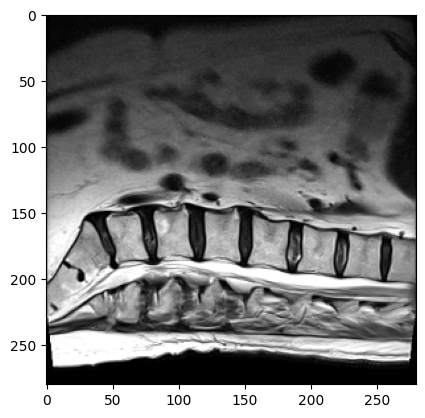

wandb: Network error (ConnectionError), entering retry loop.


: 

In [38]:
import matplotlib.pyplot as plt

plt.imshow(transformed[9]["image"][0, 30, :, :], cmap="gray")

In [33]:
bruh = monai.transforms.Compose([monai.transforms.LoadImage(image_only = False),
                                        # array.ConvertToMultiChannelBasedOnSpiderClassesdSemantic(keys=["label"]),
                                        # Spacing(
                                        # keys=["image", "label"],
                                        # pixdim=(1.0, 1.0, 1.0),
                                        # mode=("bilinear", "nearest"),
                                    # ),
                                    #   monai.transforms.Resize(keys=["image", "label"], spatial_size=(250, 250, 155)),
                                        monai.transforms.ToTensor(),])


print(bruh('/Users/tiendzung/Downloads/BraTS2021_00630/BraTS2021_00630_t2.nii.gz'))

[metatensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0.,

In [11]:
import nibabel as nib
import matplotlib.pyplot as plt

seg_out = np.zeros((100,200,3))

nib.save(nib.Nifti1Image(seg_out.astype(np.uint8), affine=None), "/Users/tiendzung/Project/spine-segmentation/notebooks/test.nii.gz")

In [12]:
img = nib.load("/Users/tiendzung/Downloads/spine_nii/masks/105_t1.nii.gz")
header = img.header
print(img.header)
print(header.get_data_shape())

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3  25 448 427   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.         3.293679   0.625      0.65749806 0.         0.
 0.         0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 40.683353
qoffset_y       : 91.359055
qoffset_z

In [13]:
print(img.affine)

[[ -3.293679     0.           0.          40.68335342]
 [  0.          -0.625        0.          91.35905457]
 [  0.           0.           0.65749806 -93.87355804]
 [  0.           0.           0.           1.        ]]


In [14]:
image_data = img.get_fdata()
print(image_data.shape)

(25, 448, 427)


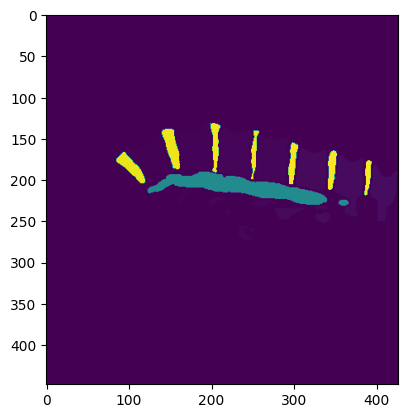

In [15]:
plt.imshow(image_data[10, :, :],)

In [70]:
affine = img.affine

affine[0, 0] = affine[0, 0] * -1
affine[1, 1] = affine[1, 1] * -1

print(affine)

nib.save(nib.Nifti1Image(image_data.astype(np.uint8), affine=affine), "/Users/tiendzung/Project/spine-segmentation/notebooks/test.nii.gz")

[[  3.293679     0.           0.          40.68335342]
 [  0.           0.625        0.          91.35905457]
 [  0.           0.           0.65749806 -93.87355804]
 [  0.           0.           0.           1.        ]]


In [17]:
test = nib.load("/Users/tiendzung/Downloads/BraTS2021_00630/BraTS2021_00630_t2.nii.gz")
print(test.header)
print(test.header.get_data_shape())

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 240 240 155   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1. 1. 1. 1. 0. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 0.0
qoffset_y       : 239.0
qoffset_z       : 0.0
srow_x          : [-1. -0. -0.  0.]
srow_y          : 

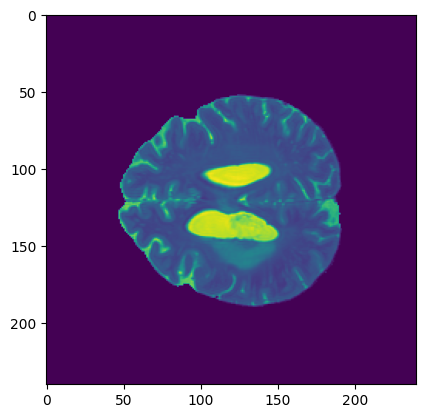

In [20]:
brats_img = test.get_fdata()

plt.imshow(brats_img[:, :, 100])